In [1]:
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# 공통 모듈 임포트
import pandas as pd
import numpy as np
import os


# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 적재

In [167]:
train_og = pd.read_csv("/content/drive/MyDrive/건설기계 오일 상태 분류 AI 경진대회/train.csv")
test = pd.read_csv("/content/drive/MyDrive/건설기계 오일 상태 분류 AI 경진대회/test.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/건설기계 오일 상태 분류 AI 경진대회/sample_submission.csv")

test = test.drop(["ID", "YEAR"], axis=1)
columns = test.columns 

train = pd.concat([train_og[columns], train_og["Y_LABEL"]], axis=1)
train

,COMPONENT_ARBITRARY,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,Y_LABEL
0,COMPONENT3,1486,200,0,0,13,78,888,0.0,16,1,6,8504,5,0,154.0,75,0
1,COMPONENT2,1350,375,0,0,0,31,2,0.0,0,0,0,19,0,0,44.0,652,0
2,COMPONENT2,2415,200,0,0,1,2,4,0.0,0,0,0,17,0,0,72.6,412,1
3,COMPONENT3,7389,200,0,0,0,1,37,0.0,1,0,0,44,0,0,133.3,7,0
4,COMPONENT3,3954,200,0,0,0,0,71,0.0,0,0,0,217,0,0,133.1,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,COMPONENT3,1616,200,0,0,0,3,23,0.0,0,0,0,35,0,0,135.4,16,0
14091,COMPONENT1,2784,200,0,0,0,2,12,0.0,0,224,0,9,0,0,117.5,1408,0
14092,COMPONENT3,1788,550,0,0,4,7,415,0.0,7,10,1,645,0,0,54.0,1301,0
14093,COMPONENT2,2498,550,0,0,0,170,19,0.0,0,1,0,11,0,0,44.3,652,0


# 데이터 정보, 시각화

In [75]:
train.head(3)

,COMPONENT_ARBITRARY,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,Y_LABEL
0,COMPONENT3,1486,200,0,0,13,78,888,0.0,16,1,6,8504,5,0,154.0,75,0
1,COMPONENT2,1350,375,0,0,0,31,2,0.0,0,0,0,19,0,0,44.0,652,0
2,COMPONENT2,2415,200,0,0,1,2,4,0.0,0,0,0,17,0,0,72.6,412,1


## data describe

In [76]:
train.describe(include="all")

,COMPONENT_ARBITRARY,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,Y_LABEL
count,14095,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000
unique,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,COMPONENT3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,7050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3146.082937,387.416885,0.025825,0.028166,3.299468,34.560624,178.169280,0.033650,2.787939,23.992409,0.730117,415.159631,0.707911,0.050656,109.355815,588.646825,0.085349
std,NaN,4216.089809,550.016073,0.171926,0.314249,28.595510,128.958953,533.208976,0.809162,11.131836,59.833922,3.806716,1528.191012,6.897579,0.475438,49.612379,531.743393,0.279411
min,NaN,1000.000000,200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.900000,0.000000,0.000000
25%,NaN,1655.000000,200.000000,0.000000,0.000000,0.000000,1.000000,14.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,71.800000,37.000000,0.000000
50%,NaN,2227.000000,200.000000,0.000000,0.000000,1.000000,4.000000,41.000000,0.000000,1.000000,1.000000,0.000000,29.000000,0.000000,0.000000,111.300000,520.000000,0.000000
75%,NaN,3797.000000,410.000000,0.000000,0.000000,3.000000,17.000000,139.000000,0.000000,2.000000,7.000000,0.000000,181.000000,0.000000,0.000000,137.200000,1119.000000,0.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   COMPONENT_ARBITRARY  14095 non-null  object 
 1   ANONYMOUS_1          14095 non-null  int64  
 2   ANONYMOUS_2          14095 non-null  int64  
 3   AG                   14095 non-null  int64  
 4   CO                   14095 non-null  int64  
 5   CR                   14095 non-null  int64  
 6   CU                   14095 non-null  int64  
 7   FE                   14095 non-null  int64  
 8   H2O                  14095 non-null  float64
 9   MN                   14095 non-null  int64  
 10  MO                   14095 non-null  int64  
 11  NI                   14095 non-null  int64  
 12  PQINDEX              14095 non-null  int64  
 13  TI                   14095 non-null  int64  
 14  V                    14095 non-null  int64  
 15  V40                  14095 non-null 

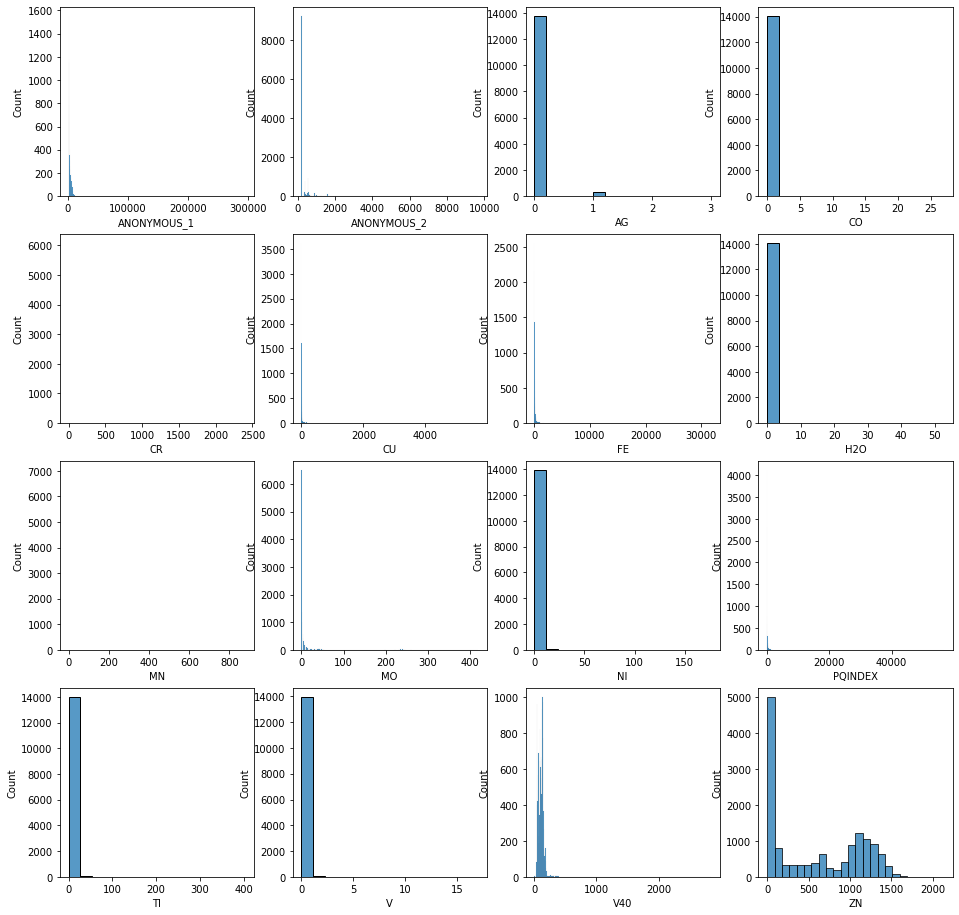

In [ ]:
numerical_columns = train.select_dtypes(exclude='object').columns.tolist()

def show_plot(df, columns):
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16,16))
    for i, column in enumerate(columns[:-1]):
        row = int(i/4)
        col = i%4
    
        sns.histplot(df[column], ax=axs[row][col])

show_plot(train, numerical_columns)

# 데이터 전처리

## one-hot encoding

In [168]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
train_component = ohe.fit_transform(train[["COMPONENT_ARBITRARY"]])

train_component

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [169]:
train = train.drop(["COMPONENT_ARBITRARY"], axis=1)
train_component = pd.DataFrame(data=train_component, columns=["component1","component2","component3","component4"])
train = pd.concat([train, train_component], axis=1)
train

,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,...,PQINDEX,TI,V,V40,ZN,Y_LABEL,component1,component2,component3,component4
0,1486,200,0,0,13,78,888,0.0,16,1,...,8504,5,0,154.0,75,0,0.0,0.0,1.0,0.0
1,1350,375,0,0,0,31,2,0.0,0,0,...,19,0,0,44.0,652,0,0.0,1.0,0.0,0.0
2,2415,200,0,0,1,2,4,0.0,0,0,...,17,0,0,72.6,412,1,0.0,1.0,0.0,0.0
3,7389,200,0,0,0,1,37,0.0,1,0,...,44,0,0,133.3,7,0,0.0,0.0,1.0,0.0
4,3954,200,0,0,0,0,71,0.0,0,0,...,217,0,0,133.1,128,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,1616,200,0,0,0,3,23,0.0,0,0,...,35,0,0,135.4,16,0,0.0,0.0,1.0,0.0
14091,2784,200,0,0,0,2,12,0.0,0,224,...,9,0,0,117.5,1408,0,1.0,0.0,0.0,0.0
14092,1788,550,0,0,4,7,415,0.0,7,10,...,645,0,0,54.0,1301,0,0.0,0.0,1.0,0.0
14093,2498,550,0,0,0,170,19,0.0,0,1,...,11,0,0,44.3,652,0,0.0,1.0,0.0,0.0


## 이상치 제거

In [170]:
# # 이상치 제거
# # 이상치 = Q3 + threshold * IQR 
# # 이상치가 너무 많음

# '''
# threshold를 기준으로 하니까 너무 데이터가 많이 삭제됨. 그래서 고정적으로 n개를 삭제하는 함수를 만들기로 결정함 
# '''

# def drop_outlier(df, threshold=5):
#     print(df.shape)
#     describe = df.describe()
#     for col in df.columns[:-5]:
#         IQR = describe.loc["75%",col] - describe.loc["25%", col]
#         outlier = describe.loc["75%",col] + IQR * threshold
#         outlier_data = df[df[col]>outlier].index
#         print("{}에서의 outlier 데이터 개수: {}".format(col, len(outlier_data)))
#         df = df.drop(df[df[col]>outlier].index, axis=0)
#     print(df.shape)
#     return outlier, df
# outlier, train = drop_outlier(train) 
# outlier

In [171]:
def drop_outlier(df, n=50):
    print("원래 데이터 크기: ",df.shape)
    outlier = pd.DataFrame()
    # 원핫 인코딩 된 컬럼은 이상치 제거 하지 않음.
    for col in df.columns[:-5]:
        if col not in ["AG", "CO", "CR", "H2O", "MN", "NI", "TI", "V"]:
            top_n = df.sort_values(by=col, ascending=False)[:n]
            outlier = outlier.append(top_n)
            top_n = top_n.index
            df = df.drop(top_n, axis=0)
    
        elif col not in ["AG", "CO", "V"]: 
            top_n = df.sort_values(by=col, ascending=False)[:5]
            outlier = outlier.append(top_n)
            top_n = top_n.index
            df = df.drop(top_n, axis=0)
    
    print("이상치 제거 후 데이터 크기: ",df.shape)
    return  outlier, df
outlier, train = drop_outlier(train) 

원래 데이터 크기:  (14095, 21)
이상치 제거 후 데이터 크기:  (13670, 21)


In [172]:
outlier_boundary = outlier.describe().iloc[6, :-5]
outlier_boundary

ANONYMOUS_1    7284.0
ANONYMOUS_2     550.0
AG                0.0
CO                0.0
CR               13.0
CU               53.0
FE             1334.0
H2O               0.0
MN               18.0
MO               37.0
NI                4.0
PQINDEX        2820.0
TI                1.0
V                 0.0
V40             170.5
ZN             1405.0
Name: 75%, dtype: float64

In [173]:
# outlier 경계가 0인 컬럼들은 내가 데이터를 보면서 수정해주었다.

outlier_boundary["AG"] = 1
outlier_boundary["CO"] = 1
outlier_boundary["H2O"] = 1
outlier_boundary["V"] = 1

dic = {}
for i, x in enumerate(outlier_boundary):
    dic[outlier_boundary.index[i]] = x

outlier_boundary = dic

outlier_boundary

{'ANONYMOUS_1': 7284.0,
 'ANONYMOUS_2': 550.0,
 'AG': 1.0,
 'CO': 1.0,
 'CR': 13.0,
 'CU': 53.0,
 'FE': 1334.0,
 'H2O': 1.0,
 'MN': 18.0,
 'MO': 37.0,
 'NI': 4.0,
 'PQINDEX': 2820.0,
 'TI': 1.0,
 'V': 1.0,
 'V40': 170.5,
 'ZN': 1405.0}

In [174]:
train_X = train.drop(["Y_LABEL"], axis=1)
train_y = train.Y_LABEL

In [175]:
train_X

,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,component1,component2,component3,component4
0,1486,200,0,0,13,78,888,0.0,16,1,6,8504,5,0,154.0,75,0.0,0.0,1.0,0.0
1,1350,375,0,0,0,31,2,0.0,0,0,0,19,0,0,44.0,652,0.0,1.0,0.0,0.0
2,2415,200,0,0,1,2,4,0.0,0,0,0,17,0,0,72.6,412,0.0,1.0,0.0,0.0
3,7389,200,0,0,0,1,37,0.0,1,0,0,44,0,0,133.3,7,0.0,0.0,1.0,0.0
4,3954,200,0,0,0,0,71,0.0,0,0,0,217,0,0,133.1,128,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,1616,200,0,0,0,3,23,0.0,0,0,0,35,0,0,135.4,16,0.0,0.0,1.0,0.0
14091,2784,200,0,0,0,2,12,0.0,0,224,0,9,0,0,117.5,1408,1.0,0.0,0.0,0.0
14092,1788,550,0,0,4,7,415,0.0,7,10,1,645,0,0,54.0,1301,0.0,0.0,1.0,0.0
14093,2498,550,0,0,0,170,19,0.0,0,1,0,11,0,0,44.3,652,0.0,1.0,0.0,0.0


In [176]:
outlier_X = outlier.drop(["Y_LABEL"], axis=1)
outlier_y = outlier.Y_LABEL 

outlier_X

,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,component1,component2,component3,component4
5970,294451,200,0,0,0,0,123,0.0,1,0,0,513,0,0,141.3,16,0.0,0.0,1.0,0.0
13469,123788,6654,0,0,1,0,92,0.0,0,2,0,93,0,0,124.3,74,0.0,0.0,1.0,0.0
3876,89350,200,0,0,0,63,34,0.0,1,4,0,33,0,0,140.0,58,0.0,0.0,1.0,0.0
8511,78418,200,0,0,3,11,28,0.0,0,0,0,24,0,0,59.1,372,0.0,1.0,0.0,0.0
212,78418,200,0,0,0,1,17,0.0,0,0,0,16,0,0,134.0,35,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13793,1363,563,0,0,3,9,208,0.0,4,6,0,255,0,0,69.9,1574,0.0,0.0,1.0,0.0
1507,4086,200,0,0,1,2,7,0.0,0,250,0,14,0,0,112.5,1572,1.0,0.0,0.0,0.0
11997,1681,550,0,0,2,5,211,0.0,4,6,0,781,0,0,70.2,1572,0.0,0.0,1.0,0.0
1857,5412,471,0,0,0,2,46,0.0,0,0,0,78,0,0,111.3,1569,0.0,0.0,1.0,0.0


In [177]:
train_X.describe()

,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,component1,component2,component3,component4
count,13670.000000,13670.000000,13670.000000,13670.000000,13670.000000,13670.000000,13670.000000,13670.000000,13670.000000,13670.000000,13670.000000,13670.000000,13670.000000,13670.000000,13670.000000,13670.000000,13670.000000,13670.000000,13670.000000,13670.000000
mean,2962.189832,363.681492,0.025311,0.020995,2.474909,29.462473,149.402999,0.016269,2.342063,22.882516,0.541185,326.991734,0.467813,0.037089,107.648596,586.828164,0.277176,0.168105,0.495538,0.059181
std,1956.612609,373.864915,0.170475,0.188749,10.390470,70.931243,313.290485,0.253151,6.279354,57.503335,1.827804,1006.848631,3.279049,0.345767,40.055288,527.038799,0.447621,0.373973,0.499998,0.235971
min,1000.000000,200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1650.250000,200.000000,0.000000,0.000000,0.000000,1.000000,14.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,71.200000,37.000000,0.000000,0.000000,0.000000,0.000000
50%,2211.000000,200.000000,0.000000,0.000000,1.000000,4.000000,40.000000,0.000000,0.000000,1.000000,0.000000,28.000000,0.000000,0.000000,110.500000,526.000000,0.000000,0.000000,0.000000,0.000000
75%,3768.500000,406.000000,0.000000,0.000000,2.000000,17.000000,134.000000,0.000000,2.000000,7.000000,0.000000,169.000000,0.000000,0.000000,136.700000,1116.000000,1.000000,0.000000,1.000000,0.000000
max,15000.000000,5422.000000,3.000000,7.000000,658.000000,709.000000,3141.000000,14.300000,110.000000,272.000000,28.000000,11752.000000,104.000000,16.000000,313.900000,1568.000000,1.000000,1.000000,1.000000,1.000000


## 정규화 하기

In [178]:
# 원핫인코딩된 컬럼을 제외하고 표준화 함(이상치 데이터는 정규화 하지 않는다).
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
standardized_train_X = pd.DataFrame(scaler.fit_transform(train_X.iloc[:, :-4]), columns = train_X.columns[:-4])


change_index = {}
for x, y in zip(standardized_train_X.index, train_X.index):
    change_index[x] = y

standardized_train_X = standardized_train_X.rename(change_index)
standardized_train_X = pd.concat([standardized_train_X, train_X.iloc[:, -4:]], axis=1)
standardized_train_X

,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,component1,component2,component3,component4
0,-0.754490,-0.437825,-0.148479,-0.111236,1.012993,0.684315,2.357633,-0.064269,2.175134,-0.380557,2.986652,8.121685,1.382216,-0.107268,1.157228,-0.971175,0.0,0.0,1.0,0.0
1,-0.824000,0.030275,-0.148479,-0.111236,-0.238199,0.021677,-0.470517,-0.064269,-0.372992,-0.397948,-0.296096,-0.305908,-0.142672,-0.107268,-1.589077,0.123661,0.0,1.0,0.0,0.0
2,-0.279672,-0.437825,-0.148479,-0.111236,-0.141953,-0.387184,-0.464133,-0.064269,-0.372992,-0.397948,-0.296096,-0.307894,-0.142672,-0.107268,-0.875037,-0.331730,0.0,1.0,0.0,0.0
3,2.262570,-0.437825,-0.148479,-0.111236,-0.238199,-0.401283,-0.358795,-0.064269,-0.213734,-0.397948,-0.296096,-0.281077,-0.142672,-0.107268,0.640423,-1.100202,0.0,0.0,1.0,0.0
4,0.506920,-0.437825,-0.148479,-0.111236,-0.238199,-0.415382,-0.250266,-0.064269,-0.372992,-0.397948,-0.296096,-0.109248,-0.142672,-0.107268,0.635430,-0.870609,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,-0.688046,-0.437825,-0.148479,-0.111236,-0.238199,-0.373086,-0.403484,-0.064269,-0.372992,-0.397948,-0.296096,-0.290016,-0.142672,-0.107268,0.692853,-1.083125,0.0,0.0,1.0,0.0
14091,-0.091074,-0.437825,-0.148479,-0.111236,-0.238199,-0.387184,-0.438596,-0.064269,-0.372992,3.497620,-0.296096,-0.315840,-0.142672,-0.107268,0.245954,1.558143,1.0,0.0,0.0,0.0
14092,-0.600136,0.498376,-0.148479,-0.111236,0.146783,-0.316691,0.847797,-0.064269,0.741813,-0.224039,0.251029,0.315857,-0.142672,-0.107268,-1.339413,1.355115,0.0,0.0,1.0,0.0
14093,-0.237250,0.498376,-0.148479,-0.111236,-0.238199,1.981393,-0.416252,-0.064269,-0.372992,-0.380557,-0.296096,-0.313854,-0.142672,-0.107268,-1.581587,0.123661,0.0,1.0,0.0,0.0


In [179]:
standardized_train_X.isnull().sum()

ANONYMOUS_1    0
ANONYMOUS_2    0
AG             0
CO             0
CR             0
CU             0
FE             0
H2O            0
MN             0
MO             0
NI             0
PQINDEX        0
TI             0
V              0
V40            0
ZN             0
component1     0
component2     0
component3     0
component4     0
dtype: int64

# 데이터셋 분류하기

In [180]:
# train_X, standardized_train_X, train_y, outlier_X, outlier_y
print("train_X shape: ", train_X.shape)
print("standardized_train_X shape: ", standardized_train_X.shape)
print("train_y shape: ", train_y.shape)
print("outlier_X shape: ", outlier_X.shape)
print("outlier_y shape: ", outlier_y.shape)

train_X shape:  (13670, 20)
standardized_train_X shape:  (13670, 20)
train_y shape:  (13670,)
outlier_X shape:  (425, 20)
outlier_y shape:  (425,)


## 검증셋 나누기

In [181]:
train_X, valid_X = train_X.iloc[2000:, :], train_X.iloc[:2000, :]
standardized_train_X , standardized_valid_X = standardized_train_X.iloc[2000:, :], standardized_train_X.iloc[:2000, :]
train_y, valid_y = train_y.iloc[2000:], train_y.iloc[:2000]
outlier_train_X, outlier_valid_X = outlier_X.iloc[150:, :], outlier_X.iloc[:150, :]
outlier_train_y, outlier_valid_y = outlier_y.iloc[150:], outlier_y.iloc[:150]

print("train_X shape: ", train_X.shape)
print("valid_X shape: ", valid_X.shape)
print("standardized_train_X shape: ", standardized_train_X.shape)
print("standardized_valid_X shape: ", standardized_valid_X.shape)
print("train_y shape: ", train_y.shape)
print("valid_y shape: ", valid_y.shape)
print("outlier_train_X shape: ", outlier_train_X.shape)
print("outlier_valid_X shape: ", outlier_valid_X.shape)
print("outlier_train_y shape: ", outlier_train_y.shape)
print("outlier_valid_y shape: ", outlier_valid_y.shape)

train_X shape:  (11670, 20)
valid_X shape:  (2000, 20)
standardized_train_X shape:  (11670, 20)
standardized_valid_X shape:  (2000, 20)
train_y shape:  (11670,)
valid_y shape:  (2000,)
outlier_train_X shape:  (275, 20)
outlier_valid_X shape:  (150, 20)
outlier_train_y shape:  (275,)
outlier_valid_y shape:  (150,)


# 모델



## 1. 이상치 데이터를 따로 학습하는 모델

### 이상치가 아닌 데이터를 학습하는 모델

In [157]:
tf.random.set_seed(42)
np.random.seed(42)

# 모델 1 훈련
normal_model = keras.models.Sequential([
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation="sigmoid")
])

In [158]:
# 조기종료를 수행하게 해주는 콜백
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)
callbacks = [early_stopping_cb]

normal_model.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])
normal_model.fit(standardized_train_X, train_y, epochs=40,
                    validation_data=(standardized_valid_X, valid_y), callbacks = callbacks)

Epoch 1/40
365/365 [==============================] - 2s 5ms/step - loss: 0.7807 - accuracy: 0.5950 - val_loss: 0.6994 - val_accuracy: 0.6225
Epoch 2/40
365/365 [==============================] - 2s 4ms/step - loss: 0.6017 - accuracy: 0.7349 - val_loss: 0.5624 - val_accuracy: 0.7925
Epoch 3/40
365/365 [==============================] - 2s 4ms/step - loss: 0.5030 - accuracy: 0.8250 - val_loss: 0.4799 - val_accuracy: 0.8715
Epoch 4/40
365/365 [==============================] - 2s 4ms/step - loss: 0.4374 - accuracy: 0.8680 - val_loss: 0.4339 - val_accuracy: 0.8930
Epoch 5/40
365/365 [==============================] - 2s 4ms/step - loss: 0.3975 - accuracy: 0.8862 - val_loss: 0.3940 - val_accuracy: 0.9010
Epoch 6/40
365/365 [==============================] - 2s 4ms/step - loss: 0.3716 - accuracy: 0.8957 - val_loss: 0.3702 - val_accuracy: 0.9050
Epoch 7/40
365/365 [==============================] - 2s 4ms/step - loss: 0.3525 - accuracy: 0.8999 - val_loss: 0.3525 - val_accuracy: 0.9105
Epoch 

### 이상치 데이터를 학습하는 모델

In [160]:
tf.random.set_seed(42)
np.random.seed(42)

# 모델 1 훈련
outlier_model = keras.models.Sequential([
    keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(8, activation="relu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation="sigmoid")
])

In [161]:
outlier_model.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

# 조기종료를 수행하게 해주는 콜백
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)
callbacks = [early_stopping_cb]

outlier_model.fit(outlier_train_X, outlier_train_y, epochs=50, 
            validation_data=(outlier_valid_X, outlier_valid_y), callbacks = callbacks)

Epoch 1/50
9/9 [==============================] - 1s 49ms/step - loss: 0.9726 - accuracy: 0.3745 - val_loss: 5.5450 - val_accuracy: 0.8867
Epoch 2/50
9/9 [==============================] - 0s 7ms/step - loss: 0.9880 - accuracy: 0.3745 - val_loss: 4.0368 - val_accuracy: 0.8867
Epoch 3/50
9/9 [==============================] - 0s 8ms/step - loss: 0.9589 - accuracy: 0.3927 - val_loss: 3.3985 - val_accuracy: 0.8867
Epoch 4/50
9/9 [==============================] - 0s 7ms/step - loss: 0.9474 - accuracy: 0.3709 - val_loss: 3.0401 - val_accuracy: 0.8867
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 0.9267 - accuracy: 0.4182 - val_loss: 2.7964 - val_accuracy: 0.8733
Epoch 6/50
9/9 [==============================] - 0s 7ms/step - loss: 0.9036 - accuracy: 0.4255 - val_loss: 2.6091 - val_accuracy: 0.8667
Epoch 7/50
9/9 [==============================] - 0s 7ms/step - loss: 0.9234 - accuracy: 0.4073 - val_loss: 2.4797 - val_accuracy: 0.8533
Epoch 8/50
9/9 [=================

# test 데이터 전처리

In [182]:
test

,COMPONENT_ARBITRARY,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,COMPONENT1,2192,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091
1,COMPONENT3,2794,200,0,0,2,1,278,0.0,3,0,0,2732,1,0,126.9,12
2,COMPONENT2,1982,200,0,0,0,16,5,0.0,0,0,0,11,0,0,44.3,714
3,COMPONENT3,1404,200,0,0,3,4,163,0.0,4,3,0,8007,0,0,142.8,94
4,COMPONENT2,8225,200,0,0,0,6,13,0.0,0,0,0,16,0,0,63.4,469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,COMPONENT3,1714,200,0,0,3,130,1047,0.0,65,5,2,1999,0,0,71.2,1163
6037,COMPONENT3,4131,200,0,0,5,2,736,0.0,5,0,0,693,0,0,137.8,13
6038,COMPONENT3,4325,200,0,0,0,0,53,0.0,0,0,0,69,0,0,302.2,13
6039,COMPONENT2,1364,200,0,0,0,62,2,0.0,0,0,0,5,0,0,51.1,478


In [234]:
def test_preprocessing(df):
    df_outlier = pd.DataFrame()
    df_component = ohe.transform(df[["COMPONENT_ARBITRARY"]])
    df = df.drop(["COMPONENT_ARBITRARY"], axis=1)
    df_component = pd.DataFrame(data=df_component, columns=["component1","component2","component3","component4"])
    df = pd.concat([df, df_component], axis=1)

    s = set()

    for col in outlier_boundary:

        df_outlier = pd.concat([df_outlier, df[df[col]>outlier_boundary[col]]], axis=0)
        s = s|set(df_outlier.index)
        df_outlier = pd.concat([df_outlier, df.iloc[df[df[col] > outlier_boundary[col]].index, :]], axis=1)


    data = df.drop(s)

    standardized_data = pd.DataFrame(scaler.transform(data.iloc[:, :-4]), columns = data.columns[:-4])

    change_index = {}
    for x, y in zip(standardized_data.index, data.index):
        change_index[x] = y



    standardized_data = standardized_data.rename(change_index)
    standardized_data = pd.concat([standardized_data, data.iloc[:, -4:]], axis=1)


    print("\ntest_X shape", data.shape)
    print("standardized_test_X shape", standardized_data.shape)
    print("outlier_test_X shape", outlier.shape)
    return data, standardized_data, df_outlier


In [235]:
test_X, standardized_test_X, outlier_test_X = test_preprocessing(test)

InvalidIndexError: ignored

In [237]:
df_outlier = pd.DataFrame()


for col in outlier_boundary:
    df_outlier = pd.concat([df_outlier, test[test[col]>outlier_boundary[col]]], axis=0)
df_outlier

,COMPONENT_ARBITRARY,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
4,COMPONENT2,8225,200,0,0,0,6,13,0.0,0,0,0,16,0,0,63.4,469
25,COMPONENT3,27301,375,0,0,2,24,65,0.0,1,0,0,75,0,0,120.3,62
39,COMPONENT3,7309,200,0,0,0,0,43,0.0,0,0,0,93,0,0,131.5,8
45,COMPONENT1,10590,9650,0,0,2,4,25,0.0,0,0,0,16,0,0,98.9,1043
48,COMPONENT3,28237,200,0,0,7,3,360,0.0,5,3,0,2009,2,0,137.4,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,COMPONENT1,1312,200,0,0,1,1,19,0.0,0,300,0,3,0,0,115.7,1636
5888,COMPONENT3,1375,386,0,0,0,19,220,0.0,3,5,0,181,0,0,112.4,1454
5893,COMPONENT1,1555,200,0,0,2,3,23,0.0,1,236,1,12,0,0,120.8,1432
5976,COMPONENT1,7269,375,0,0,3,17,30,0.0,0,255,0,7,0,0,112.5,1491


# 모델 예측 / csv파일 저장

## 1. 이상치 데이터를 따로 학습하는 모델


In [ ]:
submission_normal_outlier_01 = pd.DataFrame(sample_submission)

In [164]:
normal_predict = normal_model.predict(standardized_test_X)
outlier_predict = outlier_model.predict(outlier_test_X)

89/89 [==============================] - 0s 1ms/step


ValueError: ignored

In [ ]:
normal_index = standardized_test_X.index
outlier_index = outlier_test_X.index

for n, index in enumerate(normal_index):
    submission_normal_outlier_01.iloc[index, 1] = float(normal_predict[n])

for m, index in enumerate(outlier_index):
    submission_normal_outlier_01.iloc[index, 1] = float(outlier_predict[m])

In [ ]:
for i in range(submission_normal_outlier_01.shape[0]):
    if submission_normal_outlier_01.iloc[i, 1] >= 0.5:   
        submission_normal_outlier_01.iloc[i,1] = 1 
    else:
        submission_normal_outlier_01.iloc[i,1] = 0

In [ ]:
submission_normal_outlier_01.to_csv("C:\Users\user\Desktop\machine_learning\machine-learning\dacon\submission_normal_outlier_01")

SyntaxError: ignored

In [162]:
def save_predict_outlier(n):
    submission = pd.DataFrame(sample_submission)

    normal_predict = normal_model.predict(standardized_test_X)
    outlier_predict = outlier_model.predict(outlier_test_X)

    normal_index = standardized_test_X.index
    outlier_index = outlier_test_X.index

    for n, index in enumerate(normal_index):
        submission.iloc[index, 1] = float(normal_predict[n])

    for m, index in enumerate(outlier_index):
        submission.iloc[index, 1] = float(outlier_predict[m])

    for i in range(submission.shape[0]):
        if submission.iloc[i, 1] >= 0.5:   
            submission.iloc[i,1] = 1 
        else:
            submission.iloc[i,1] = 0
    
    submission.to_csv("/content/drive/MyDrive/건설기계 오일 상태 분류 AI 경진대회/predict/outlier_normal_{}".format(n))

In [163]:
save_predict_outlier("01")

89/89 [==============================] - 0s 2ms/step


ValueError: ignored

In [ ]:
("/content/drive/MyDrive/건설기계 오일 상태 분류 AI 경진대회/predict/outlier_normal_{}".format("01"))

'/content/drive/MyDrive/건설기계 오일 상태 분류 AI 경진대회/predict/outlier_normal_01'